### Imports

In [98]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, inspect
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

### Data retrieval

In [99]:
# Path to your SQLite database
sqlite_file_path = 'archive/travel.sqlite'

# Create a connection to the SQLite database
engine = create_engine(f'sqlite:///{sqlite_file_path}')

# Create an inspector object
inspector = inspect(engine)

# Retrieve the list of tables from the database
tables = inspector.get_table_names()

# Dictionary to hold table data
tables_with_columns = {}

# Dictionary to hold DataFrames for each table
dfs = {}

# Load data from each table into a DataFrame and store it in the dictionary
for table in tables:
    # Fetch data as strings to avoid dtype conversion issues
    query = f'SELECT * FROM {table}'
    dfs[table] = pd.read_sql_query(query, engine)


In [97]:
merged_df.columns

Index(['book_ref', 'book_date', 'total_amount', 'ticket_no', 'passenger_id',
       'flight_id', 'fare_conditions', 'amount', 'flight_no',
       'scheduled_departure', 'scheduled_arrival', 'departure_airport',
       'arrival_airport', 'status', 'aircraft_code', 'actual_departure',
       'actual_arrival', 'Departure: airport_code', 'Departure: airport_name',
       'Departure: city', 'Departure: coordinates', 'Departure: timezone',
       'Arrival: airport_code', 'Arrival: airport_name', 'Arrival: city',
       'Arrival: coordinates', 'Arrival: timezone', 'model', 'range',
       'Days Until Departure', 'Cumulative Revenue', 'Weekday of Flight'],
      dtype='object')

### Data preperation
To enhance data accessibility, all information is consolidated into a single dataframe, with each row representing a booking and its associated details. This structure ensures that data can be easily accessed and updated as required. Additionally, three new columns, 'Days Until Departure', 'Cumulative Revenue,' and 'Weekday of Flight' have been introduced. 'Days Until Departure' is defined as the number of days between the booking date and the scheduled departure date. 'Cumulative Revenue' represents the total revenue accumulated up to and including the current day. This is crucial for the regression phase as the Cumulative Revenue will be the predicted value. The 'Weekday of Flight' feature represents the day of departure, offering insightful data on booking patterns.

The data is interconnected through specific fields. To associate bookings with flights, they are initially connected using the 'book_ref' variable to the 'tickets' table. Subsequently, the 'ticket_no' variable in the 'tickets' table is used to link to 'ticket flights.' Finally, these records are connected to the 'flights' data using their 'flight_id.' This method ensures accurate matching of all related data.


In [31]:
departure_airports = dfs["airports_data"].add_prefix("Departure: ")
arrival_airports = dfs["airports_data"].add_prefix("Arrival: ")
merged_df = pd.merge(dfs["bookings"], dfs["tickets"], on='book_ref')
merged_df = pd.merge(merged_df, dfs["ticket_flights"], on='ticket_no')
merged_df = pd.merge(merged_df, dfs["flights"], on='flight_id')
merged_df = pd.merge(merged_df, departure_airports, left_on="departure_airport", right_on="Departure: airport_code", how="left")
merged_df = pd.merge(merged_df, arrival_airports, left_on="arrival_airport", right_on="Arrival: airport_code", how="left")
merged_df = pd.merge(merged_df, dfs["aircrafts_data"], on='aircraft_code')
merged_df['Days Until Departure'] = (pd.to_datetime(merged_df['scheduled_departure']) - (pd.to_datetime(merged_df['book_date']))).dt.days
merged_df.sort_values(by='book_date', inplace=True)
merged_df['Cumulative Revenue'] = merged_df.groupby('flight_id')['total_amount'].cumsum()
merged_df['Weekday of Flight'] = pd.to_datetime(merged_df['scheduled_departure'], errors='coerce') .dt.day_name()
columns_to_keep = columns_to_keep = ['flight_id', 'flight_no', 'scheduled_departure', 'Weekday of Flight']
merged_df.head(10)

,book_ref,book_date,total_amount,ticket_no,passenger_id,flight_id,fare_conditions,amount,flight_no,scheduled_departure,...,Arrival: airport_code,Arrival: airport_name,Arrival: city,Arrival: coordinates,Arrival: timezone,model,range,Days Until Departure,Cumulative Revenue,Weekday of Flight
975363,61EAC7,2017-06-21 14:05:00+03,52000,0005432628587,0093 271823,7226,Economy,13000,PG0128,2017-07-16 11:00:00+03,...,ASF,"{""en"": ""Astrakhan Airport"", ""ru"": ""Астрахань""}","{""en"": ""Astrakhan"", ""ru"": ""Астрахань""}","(48.0063018799000005,46.2832984924000002)",Europe/Samara,"{""en"": ""Bombardier CRJ-200"", ""ru"": ""Бомбардье ...",2700,24,52000,Sunday
967737,61EAC7,2017-06-21 14:05:00+03,52000,0005432628587,0093 271823,28146,Economy,13000,PG0129,2017-07-21 13:05:00+03,...,SVO,"{""en"": ""Sheremetyevo International Airport"", ""...","{""en"": ""Moscow"", ""ru"": ""Москва""}","(37.4146000000000001,55.9725990000000024)",Europe/Moscow,"{""en"": ""Bombardier CRJ-200"", ""ru"": ""Бомбардье ...",2700,29,52000,Friday
967738,61EAC7,2017-06-21 14:05:00+03,52000,0005432628588,1700 690956,28146,Economy,13000,PG0129,2017-07-21 13:05:00+03,...,SVO,"{""en"": ""Sheremetyevo International Airport"", ""...","{""en"": ""Moscow"", ""ru"": ""Москва""}","(37.4146000000000001,55.9725990000000024)",Europe/Moscow,"{""en"": ""Bombardier CRJ-200"", ""ru"": ""Бомбардье ...",2700,29,104000,Friday
975364,61EAC7,2017-06-21 14:05:00+03,52000,0005432628588,1700 690956,7226,Economy,13000,PG0128,2017-07-16 11:00:00+03,...,ASF,"{""en"": ""Astrakhan Airport"", ""ru"": ""Астрахань""}","{""en"": ""Astrakhan"", ""ru"": ""Астрахань""}","(48.0063018799000005,46.2832984924000002)",Europe/Samara,"{""en"": ""Bombardier CRJ-200"", ""ru"": ""Бомбардье ...",2700,24,104000,Sunday
168353,98A065,2017-06-21 15:48:00+03,211100,0005434876589,2496 629437,14584,Economy,11700,PG0413,2017-07-28 18:55:00+03,...,VKO,"{""en"": ""Vnukovo International Airport"", ""ru"": ...","{""en"": ""Moscow"", ""ru"": ""Москва""}","(37.2615013122999983,55.5914993286000012)",Europe/Moscow,"{""en"": ""Boeing 777-300"", ""ru"": ""Боинг 777-300""}",11100,37,211100,Friday
168354,98A065,2017-06-21 15:48:00+03,211100,0005434876590,4813 255607,14584,Economy,11700,PG0413,2017-07-28 18:55:00+03,...,VKO,"{""en"": ""Vnukovo International Airport"", ""ru"": ...","{""en"": ""Moscow"", ""ru"": ""Москва""}","(37.2615013122999983,55.5914993286000012)",Europe/Moscow,"{""en"": ""Boeing 777-300"", ""ru"": ""Боинг 777-300""}",11100,37,422200,Friday
168355,98A065,2017-06-21 15:48:00+03,211100,0005434876591,0849 378091,14584,Comfort,19900,PG0413,2017-07-28 18:55:00+03,...,VKO,"{""en"": ""Vnukovo International Airport"", ""ru"": ...","{""en"": ""Moscow"", ""ru"": ""Москва""}","(37.2615013122999983,55.5914993286000012)",Europe/Moscow,"{""en"": ""Boeing 777-300"", ""ru"": ""Боинг 777-300""}",11100,37,633300,Friday
145990,98A065,2017-06-21 15:48:00+03,211100,0005434876591,0849 378091,3490,Economy,11700,PG0412,2017-07-16 11:00:00+03,...,PEE,"{""en"": ""Bolshoye Savino Airport"", ""ru"": ""Пермь""}","{""en"": ""Perm"", ""ru"": ""Пермь""}","(56.021198272705,57.9145011901860016)",Asia/Yekaterinburg,"{""en"": ""Boeing 777-300"", ""ru"": ""Боинг 777-300""}",11100,24,211100,Sunday
145989,98A065,2017-06-21 15:48:00+03,211100,0005434876590,4813 255607,3490,Economy,11700,PG0412,2017-07-16 11:00:00+03,...,PEE,"{""en"": ""Bolshoye Savino Airport"", ""ru"": ""Пермь""}","{""en"": ""Perm"", ""ru"": ""Пермь""}","(56.021198272705,57.9145011901860016)",Asia/Yekaterinburg,"{""en"": ""Boeing 777-300"", ""ru"": ""Боинг 777-300""}",11100,24,422200,Sunday
145988,98A065,2017-06-21 15:48:00+03,211100,0005434876589,2496 629437,3490,Economy,11700,PG0412,2017-07-16 11:00:00+03,...,PEE,"{""en"": ""Bolshoye Savino Airport"", ""ru"": ""Пермь""}","{""en"": ""Perm"", ""ru"": ""Пермь""}","(56.021198272705,57.9145011901860016)",Asia/Yekaterinburg,"{""en"": ""Boeing 777-300"", ""ru"": ""Боинг 777-300""}",11100,24,633300,Sunday


The analysis performed in the subsequent cell reveals the absence of data for flight "PG0708" on September 15th. Consequently, for this assessment, another flight will be selected at random for the prediction phase; specifically, the flight on June 25th, 2017, has been chosen. In crafting our predictive model, we will restrict our dataset to include only flights sharing the same flight number as the target flight ("PG0708"). This decision ensures that the data utilized is directly relevant to the flight in question, enhancing the accuracy and relevancy of our predictions.

While it is feasible to develop a more generalized model that encompasses data from all flights to identify overarching trends, such an approach is currently impractical due to time and resource constraints. Therefore, we will focus on constructing a model tailored specifically to the chosen flight. This targeted approach allows for a more manageable and efficient analysis, ensuring that the resulting predictions are both relevant and achievable within the limitations imposed.

Limiting the analysis to flights sharing the same flight number can significantly enhance the accuracy and relevance of the assessment for several reasons:

- Aircraft Similarity: Focusing on a single flight number often means analyzing data for the same or similar types of aircraft. This approach eliminates variations caused by different aircraft performances, ensuring that the predictive model accurately reflects the specific characteristics and operational behaviors of the aircraft in question.

- Consistency and Schedule Regularity: Flights that operate under the same flight number typically maintain consistent routes and schedules. This regularity is crucial for evaluating factors such as departure times, seasonal impacts, and day-of-the-week trends without the interference of varied flight patterns. Such consistency ensures that the data reflects uniform operational conditions, making the analysis more straightforward and the predictions more reliable.

- Historical Data Comparisons: Analyzing flights with identical flight numbers enables direct comparison of historical data, facilitating a clear understanding of trends, anomalies, and performance over time. This continuity is vital for identifying long-term patterns and changes in flight performance, providing a solid foundation for predictive analysis and decision-making.

By concentrating on these aspects, the analysis ensures that the model is built on homogeneous and relevant data, thereby improving the robustness and applicability of the predictive outcomes.

In [32]:
relevant_flight_df = merged_df[(merged_df["flight_no"] == "PG0708")]
if (relevant_flight_df['scheduled_departure'].str.contains('2017-09-15')).any():
    print("Exists")

In [71]:
relevant_flight_df.head(10)

,book_ref,book_date,total_amount,ticket_no,passenger_id,flight_id,fare_conditions,amount,flight_no,scheduled_departure,...,Arrival: airport_code,Arrival: airport_name,Arrival: city,Arrival: coordinates,Arrival: timezone,model,range,Days Until Departure,Cumulative Revenue,Weekday of Flight
391012,E02C9A,2017-06-25 10:41:00+03,130300,0005433284774,4091 993051,32042,Economy,5200,PG0708,2017-07-16 17:15:00+03,...,OVS,"{""en"": ""Sovetskiy Airport"", ""ru"": ""Советский""}","{""en"": ""Sovetskiy"", ""ru"": ""Советский""}","(63.6019134521484375,61.3266220092773438)",Asia/Yekaterinburg,"{""en"": ""Boeing 737-300"", ""ru"": ""Боинг 737-300""}",4200,21,130300,Sunday
391013,E02C9A,2017-06-25 10:41:00+03,130300,0005433284775,8872 147125,32042,Economy,5200,PG0708,2017-07-16 17:15:00+03,...,OVS,"{""en"": ""Sovetskiy Airport"", ""ru"": ""Советский""}","{""en"": ""Sovetskiy"", ""ru"": ""Советский""}","(63.6019134521484375,61.3266220092773438)",Asia/Yekaterinburg,"{""en"": ""Boeing 737-300"", ""ru"": ""Боинг 737-300""}",4200,21,260600,Sunday
406637,8B251D,2017-06-25 15:48:00+03,85200,0005435103805,5601 507068,32063,Economy,5200,PG0708,2017-07-30 17:15:00+03,...,OVS,"{""en"": ""Sovetskiy Airport"", ""ru"": ""Советский""}","{""en"": ""Sovetskiy"", ""ru"": ""Советский""}","(63.6019134521484375,61.3266220092773438)",Asia/Yekaterinburg,"{""en"": ""Boeing 737-300"", ""ru"": ""Боинг 737-300""}",4200,35,85200,Sunday
406636,8B251D,2017-06-25 15:48:00+03,85200,0005435103804,5617 024226,32063,Economy,5200,PG0708,2017-07-30 17:15:00+03,...,OVS,"{""en"": ""Sovetskiy Airport"", ""ru"": ""Советский""}","{""en"": ""Sovetskiy"", ""ru"": ""Советский""}","(63.6019134521484375,61.3266220092773438)",Asia/Yekaterinburg,"{""en"": ""Boeing 737-300"", ""ru"": ""Боинг 737-300""}",4200,35,170400,Sunday
406661,F9924A,2017-06-25 21:38:00+03,53100,0005435103801,1389 333793,32063,Economy,5200,PG0708,2017-07-30 17:15:00+03,...,OVS,"{""en"": ""Sovetskiy Airport"", ""ru"": ""Советский""}","{""en"": ""Sovetskiy"", ""ru"": ""Советский""}","(63.6019134521484375,61.3266220092773438)",Asia/Yekaterinburg,"{""en"": ""Boeing 737-300"", ""ru"": ""Боинг 737-300""}",4200,34,223500,Sunday
391004,A92E73,2017-06-26 02:24:00+03,42800,0005433284770,0757 331632,32042,Economy,5200,PG0708,2017-07-16 17:15:00+03,...,OVS,"{""en"": ""Sovetskiy Airport"", ""ru"": ""Советский""}","{""en"": ""Sovetskiy"", ""ru"": ""Советский""}","(63.6019134521484375,61.3266220092773438)",Asia/Yekaterinburg,"{""en"": ""Boeing 737-300"", ""ru"": ""Боинг 737-300""}",4200,20,303400,Sunday
390999,827ADE,2017-06-26 03:46:00+03,42800,0005433284776,7170 534123,32042,Economy,5200,PG0708,2017-07-16 17:15:00+03,...,OVS,"{""en"": ""Sovetskiy Airport"", ""ru"": ""Советский""}","{""en"": ""Sovetskiy"", ""ru"": ""Советский""}","(63.6019134521484375,61.3266220092773438)",Asia/Yekaterinburg,"{""en"": ""Boeing 737-300"", ""ru"": ""Боинг 737-300""}",4200,20,346200,Sunday
381208,2C09F2,2017-06-26 06:16:00+03,53300,0005433284837,2306 226802,32052,Economy,5200,PG0708,2017-07-18 17:15:00+03,...,OVS,"{""en"": ""Sovetskiy Airport"", ""ru"": ""Советский""}","{""en"": ""Sovetskiy"", ""ru"": ""Советский""}","(63.6019134521484375,61.3266220092773438)",Asia/Yekaterinburg,"{""en"": ""Boeing 737-300"", ""ru"": ""Боинг 737-300""}",4200,22,53300,Tuesday
398036,190B5D,2017-06-26 13:34:00+03,43100,0005435103815,6477 652495,32070,Economy,5200,PG0708,2017-07-29 17:15:00+03,...,OVS,"{""en"": ""Sovetskiy Airport"", ""ru"": ""Советский""}","{""en"": ""Sovetskiy"", ""ru"": ""Советский""}","(63.6019134521484375,61.3266220092773438)",Asia/Yekaterinburg,"{""en"": ""Boeing 737-300"", ""ru"": ""Боинг 737-300""}",4200,33,43100,Saturday
390996,560B9B,2017-06-27 02:59:00+03,85800,0005433284791,9235 626527,32042,Business,15700,PG0708,2017-07-16 17:15:00+03,...,OVS,"{""en"": ""Sovetskiy Airport"", ""ru"": ""Советский""}","{""en"": ""Sovetskiy"", ""ru"": ""Советский""}","(63.6019134521484375,61.3266220092773438)",Asia/Yekaterinburg,"{""en"": ""Boeing 737-300"", ""ru""

In the code below, the data preparation process is outlined for a dataset concerning flight information. Initially, it ensures that the 'Days Until Departure' and 'amount' columns in the dataframe are converted to numeric types, which is crucial for mathematical and statistical analysis; errors during conversion are handled by coercing them into NaN values. This conversion facilitates accurate calculations and comparisons later in the analysis.

The code then constructs a template dataframe containing a sequence of values representing days until departure, ranging from 30 days out to 1 day. This step is important for creating a standardized timeline for all flights, ensuring that subsequent analyses can uniformly compare flight data over a consistent time frame.

Following the setup, a custom function is defined to merge the existing flight data with this template, thereby guaranteeing that each flight has records for all possible days in the 30-day pre-departure period. This approach addresses gaps in the original data, ensuring no days are missing, which could skew analysis results.

Within this function, missing values, particularly in 'Cumulative Revenue', are forward-filled, meaning that the last known value is used to fill subsequent gaps. This method makes sense for cumulative data, where the last recorded total would naturally carry over until a new transaction occurs. Additionally, for any missing days, specific flight information such as 'flight_id' and 'scheduled_departure' is populated from the existing records to maintain data integrity and continuity.

Finally, this transformation function is applied to each group of data identified by 'flight_id', ensuring that the modifications are made on a per-flight basis. This approach allows for an individual and detailed analysis of each flight's pre-departure period. The resulting expanded dataset, now filled and continuous, is then copied for further use or analysis, ensuring that the original dataset remains unaltered and available for other purposes. This meticulous data preparation is fundamental for conducting accurate and comprehensive predictive analyses, particularly when dealing with time-series data or preparing for regression models.

In [36]:
# Make sure 'Days Until Departure'
relevant_flight_df.loc[:, 'Days Until Departure'] = pd.to_numeric(merged_df['Days Until Departure'], errors='coerce')
# Prepare a DataFrame template with all possible 'Days Until Departure' values (from 0 to 29)
all_days_df = pd.DataFrame({'Days Until Departure': range(30, 0, -1)})  # 30 days to 1 day before departure

# Function to merge existing data with the full 30-day range, ensuring all days are represented
def expand_flight_data(group):
    # Merge to ensure all days are represented
    merged = all_days_df.merge(group, on='Days Until Departure', how='left')
    
    # Fill in 'flight_id' for all rows (needed if the group has missing days)
    merged['flight_id'] = group['flight_id'].iloc[0]
    
    merged['Cumulative Revenue'] = merged['Cumulative Revenue'].fillna(method='ffill').fillna(0)
    for column in columns_to_keep:
        merged[column] = group[column].iloc[0]
    return merged

# Apply to each flight group
expanded_df = relevant_flight_df.groupby('flight_id').apply(expand_flight_data).reset_index(drop=True)
df = expanded_df.copy()

In the code below, the dataset undergoes a series of transformations to prepare it for further analysis, focusing particularly on date and time features.

Initially, the 'scheduled_departure' column is converted into a datetime format, ensuring that subsequent operations involving dates and times are correctly executed. This conversion is essential for performing accurate date arithmetic and facilitating time-based grouping and sorting.

Next, a new column, 'computed_book_date', is created by subtracting the 'Days Until Departure' from the 'scheduled_departure' date. This computation effectively reconstructs the original booking date for each flight, serving as a basis for extracting further time-related features.

The dataset then undergoes feature engineering based on the 'computed_book_date' to extract meaningful insights:

- Weekday vs. Weekend: This new feature classifies days into 'Weekend' or 'Weekday' based on the day of the week, which is important for analyzing booking patterns and demand fluctuations.

- Part of Month: The month is divided into three parts ('Early', 'Mid', and 'Late'), providing a simplified view of monthly booking trends and enabling the identification of peak periods within a month.

- Seasonality: This feature categorizes dates into seasons ('Spring', 'Summer', 'Fall', 'Winter'), facilitating the analysis of seasonal impacts on flight bookings and revenues.

Additionaly, the dataframe is sorted by 'flight_id' and 'computed_book_date' to ensure that data aligns chronologically for each flight, crucial for accurate trend analysis and cumulative calculations. The 'computed_book_date' and 'scheduled_departure' columns are then removed to focus the dataset on the derived features and relevant analytical dimensions. The index is reset post-sorting to maintain data integrity and ease of access.

Finally, the columns containing NaN values are excluded from the dataset because they lack valuable information for making predictions.

In [37]:
# Ensure 'scheduled_departure' is a datetime
df['scheduled_departure'] = pd.to_datetime(df['scheduled_departure'])

# Compute 'computed_book_date' from 'scheduled_departure' and 'Days Until Departure'
df['computed_book_date'] = df['scheduled_departure'] - pd.to_timedelta(df['Days Until Departure'], unit='d')

# Now, create the features based on 'computed_book_date':

# Weekday vs. Weekend
df['Weekday vs. Weekend'] = df['computed_book_date'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Part of Month
def part_of_month(day):
    if day <= 10:
        return 'Early'
    elif day <= 20:
        return 'Mid'
    else:
        return 'Late'

df['Part of Month'] = df['computed_book_date'].dt.day.apply(part_of_month)

# Seasonality
def season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

df['Seasonality'] = df['computed_book_date'].dt.month.apply(season)

# Flight ID (no change needed, just ensure it's treated as categorical)
df['flight_id'] = df['flight_id'].astype('category')
df = df.sort_values(by=['flight_id', 'computed_book_date'])

df = df.drop("computed_book_date", axis=1)
df = df.drop("scheduled_departure", axis=1)
# Reset the index after sorting
df.reset_index(drop=True, inplace=True)
cleaned_df = df.dropna(axis=1)

In the context of handling multiple bookings per day, the dataset must be refined to reflect a single, consolidated record for each day to ensure clarity and consistency in daily trend analysis. To address this, the data is aggregated in such a way that only the latest booking of the day is retained. This method is chosen because the most recent booking within any given day is likely to reflect the final cumulative revenue for that day, capturing the day's total revenue activity. By consolidating the data in this manner, each row in the dataset now represents a unique day, streamlining the dataset into a daily time series format that is more manageable and analytically useful.

Building on this structured dataset, an additional step involves the creation of a new column that captures the 'Previous Cumulative Revenue'—the total revenue accumulated up to the day before. This feature is particularly important for predictive modeling, as it provides insight into the revenue progression and can significantly enhance the accuracy of forecasts for future revenue. By incorporating the revenue from the previous day as a predictor, the model can leverage historical revenue trends to make more informed predictions about future revenue trajectories, thus turning the day-to-day revenue changes into a valuable asset for forecasting the following day's revenue.

In [38]:
columns_to_aggregate = cleaned_df.columns.difference(['Days Until Departure', 'flight_id'])
agg_dict = {col: 'last' for col in columns_to_aggregate}
training_df = cleaned_df.groupby(['Days Until Departure', 'flight_id']).agg(agg_dict).reset_index()
training_df['Previous Cumulative Revenue'] = training_df.groupby('flight_id')['Cumulative Revenue'].shift(-1).fillna(0)

In the data preprocessing phase, the transformation begins with one-hot encoding of categorical variables using a OneHotEncoder, converting attributes such as flight numbers and time-related categories into binary form to eliminate any ordinal relationships that could mislead machine learning models. 

The numerical attributes remain unchanged, given that the target variable, cumulative revenue, is a continuous variable without a predefined range. Additionally, the 'Days Before Departure' feature is appropriately structured, embodying an ordinal value that effectively captures the sequential nature of the days leading up to departure.

In [41]:
# Select columns with numerical data types
# numerical_columns = training_df.select_dtypes(include=['number']).columns.tolist()

# Select columns with categorical data types
categorical_columns = training_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical Columns:", numerical_columns)
print("Categorical Columns:", categorical_columns)

Numerical Columns: ['Days Until Departure', 'Cumulative Revenue', 'Previous Cumulative Revenue']
Categorical Columns: ['flight_id', 'Part of Month', 'Seasonality', 'Weekday of Flight', 'Weekday vs. Weekend', 'flight_no']


In [78]:
ohe = OneHotEncoder(sparse=False)
scaler = MinMaxScaler()
# categorical_columns = ['flight_no', 'Part of Month', 'Seasonality', 'Weekday vs. Weekend']

categorical_encoded = ohe.fit_transform(training_df[categorical_columns])
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=ohe.get_feature_names_out(categorical_columns))

# Normalization for numerical data
scaler = MinMaxScaler()  # Initialize min-max scaler
# numerical_columns = ['Cumulative Revenue','Previous Cumulative Revenue']
# numerical_normalized = scaler.fit_transform(training_df[numerical_columns])
# numerical_normalized_df = pd.DataFrame(numerical_normalized, columns=numerical_columns)

# Concatenate back to a single DataFrame
remaining_columns = training_df.columns.difference(categorical_columns )
remaining_df = training_df[remaining_columns]

processed_df = pd.concat([categorical_encoded_df, remaining_df], axis=1)

/home/tycho/py3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [79]:
processed_df.head(10)

,flight_id_32040,flight_id_32041,flight_id_32042,flight_id_32043,flight_id_32044,flight_id_32045,flight_id_32046,flight_id_32047,flight_id_32048,flight_id_32049,...,Weekday of Flight_Sunday,Weekday of Flight_Thursday,Weekday of Flight_Tuesday,Weekday of Flight_Wednesday,Weekday vs. Weekend_Weekday,Weekday vs. Weekend_Weekend,flight_no_PG0708,Cumulative Revenue,Days Until Departure,Previous Cumulative Revenue
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1854600.0,1,1854600.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,3326900.0,1,3326900.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1921200.0,1,1921200.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3200500.0,1,3200500.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4336800.0,1,4336800.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2952400.0,1,2952400.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3009700.0,1,3009700.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2545400.0,1,2545400.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2709900.0,1,2709900.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2287100.0,1,2287100.0


The code below is to remove the targeted flight, which is flight 32040, from the training data such that it can be used in the final prediction.

In [80]:
flight_to_test = processed_df[processed_df["flight_id_32040"] == 1]
processed_df = processed_df[processed_df["flight_id_32040"] != 1]

The dataset is divided into two subsets: 70% of the data is allocated for training purposes, and the remaining 30% is reserved for testing. This split is uniquely structured based on the flight_ids, ensuring that data pertaining to any given flight is exclusively contained either in the training set or in the testing set, but not both. This methodological approach is particularly important as it prevents data leakage between the training and testing phases and ensures the integrity of the evaluation process. By segregating the data in this manner, the model is trained on a diverse set of flights, enabling it to learn and generalize patterns across different flights on the same route effectively. This strategy enhances the model's ability to predict trends and behaviors for unseen flights, providing a more robust understanding of flight-specific dynamics and market demands.

In [81]:
# Identifying the flight_id columns
flight_id_columns = [col for col in processed_df.columns if col.startswith('flight_id_')]

# Extracting the flight IDs from the rows
flights = {}
for column in flight_id_columns:
    flight_rows = processed_df[processed_df[column] == 1]
    flights[column] = flight_rows

# Creating a list of flight IDs to be used for splitting
flight_ids = list(flights.keys())

# Splitting flight IDs into training and testing sets
train_flight_ids, test_flight_ids = train_test_split(flight_ids, test_size=0.3, random_state=42)

# Combining the individual flight DataFrames based on the split
train_frames = [flights[flight_id] for flight_id in train_flight_ids]
test_frames = [flights[flight_id] for flight_id in test_flight_ids]
# Creating the training and testing dataframes
train_df = pd.concat(train_frames)
test_df = pd.concat(test_frames)

In this section of the analysis, the focus is on optimizing the parameters 'learning rate' and 'max depth' to develop the most effective predictive model for cumulative revenue. The optimization process involves adjusting these parameters to find the combination that minimizes prediction errors, thereby enhancing the model's accuracy and reliability.

XGBoost was selected for its proficiency in handling time-series data efficiently, making it well-suited for forecasting tasks like predicting cumulative revenue over time. This choice is particularly appealing because XGBoost achieves high accuracy without requiring extensive computational resources, contrasting with models like LSTM. While LSTM networks are excellent for capturing complex temporal dependencies, their need for more computational power and longer training times makes them less practical under resource constraints. Therefore, XGBoost stands out as the preferred model, offering an effective balance between performance and computational efficiency, making it an optimal choice for this forecasting problem within the given resource limitations.

The choice of Root Mean Square Error (RMSE) as the metric for optimization, over Mean Squared Error (MSE), is deliberate. RMSE is selected because it provides error measurements in the same units as the predicted variable, which, in this case, is the cumulative revenue. This congruence allows for more intuitive understanding and communication of the model's performance. Furthermore, RMSE emphasizes larger errors more than smaller ones by squaring the errors before averaging and then taking the square root of the result. This characteristic is particularly advantageous when predicting cumulative revenue, as larger forecasting errors can have more significant implications for business decisions and financial planning. By prioritizing the reduction of larger errors, RMSE aligns the model's optimization with business objectives, ensuring that the developed model is not only statistically sound but also practically relevant in minimizing costly prediction inaccuracies.

In [87]:

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
}

# Initialize the XGBRegressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=42, enable_categorical=True)

# Set up the grid search with 5-fold cross-validation
grid_cv = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the Grid Search to the data
grid_cv.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best parameters found: {grid_cv.best_params_}")
print(f"Lowest RMSE found: {np.sqrt(-grid_cv.best_score_)}")

# Re-train the model on the full dataset using the best parameters
xgb_model_optimized = xgb.XGBRegressor(**grid_cv.best_params_, objective='reg:squarederror', seed=42, enable_categorical=True)
xgb_model_optimized.fit(X_train, y_train)

# Making predictions and evaluating the optimized model
predictions_optimized = xgb_model_optimized.predict(X_test)
mse_optimized = mean_squared_error(y_test, predictions_optimized)
r2_optimized = r2_score(y_test, predictions_optimized)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3}
Lowest RMSE found: 221066.3858142198


The model, having been optimized, is now set to predict the cumulative revenue for flight 32040. Utilizing the previously predicted cumulative revenue as a baseline, the model aims to forecast the revenue increment from 30 days before departure, providing an evolving prediction of the flight's total revenue accumulation over time. This approach enables a dynamic understanding of how the flight's revenue is expected to grow as the departure date approaches, allowing for a detailed and time-specific revenue projection.

In [91]:
flight_to_test_Y = flight_to_test['Cumulative Revenue']

flight_to_test_X = flight_to_test.drop(['Cumulative Revenue'], axis=1)
previous_cumu = 0
test_predictions = []
i = 0
for index, row in flight_to_test_X.iterrows():
    if i > -1:
        row["Previous Cumulative Revenue"] = previous_cumu
    row = row.values.reshape(1, -1)
    test_prediction = xgb_model_optimized.predict(row)
    test_predictions.append(test_prediction)
    previous_cumu = test_prediction
    i += 1
test_predictions_reversed = test_predictions[::-1]


In the analysis below, the feature importances derived from the optimized model are presented. Notably, 'Previous Cumulative Revenue' emerges as a highly influential factor in predicting the cumulative revenue. This observation aligns with expectations, considering that the model's predictions are based on historical revenue data, effectively building on past values to forecast future earnings. The 'Days Until Departure' also demonstrates notable significance, indicating its impact on revenue predictions, which underscores the temporal dynamics influencing flight bookings and associated revenue.

Additionally, the analysis reveals that Wednesdays stand out among weekdays in terms of feature importance. This heightened significance suggests that Wednesday flights may be more popular, possibly because travelers prefer flying midweek to reach their destination before the weekend. This trend could logically lead to an increased volume of bookings and, consequently, higher revenue accumulation for flights scheduled on this day. The increased importance of Wednesdays in the model highlights potential consumer behavior patterns, suggesting that strategic pricing or promotional efforts on these days could capitalize on the observed increase in demand, thereby boosting revenue further.

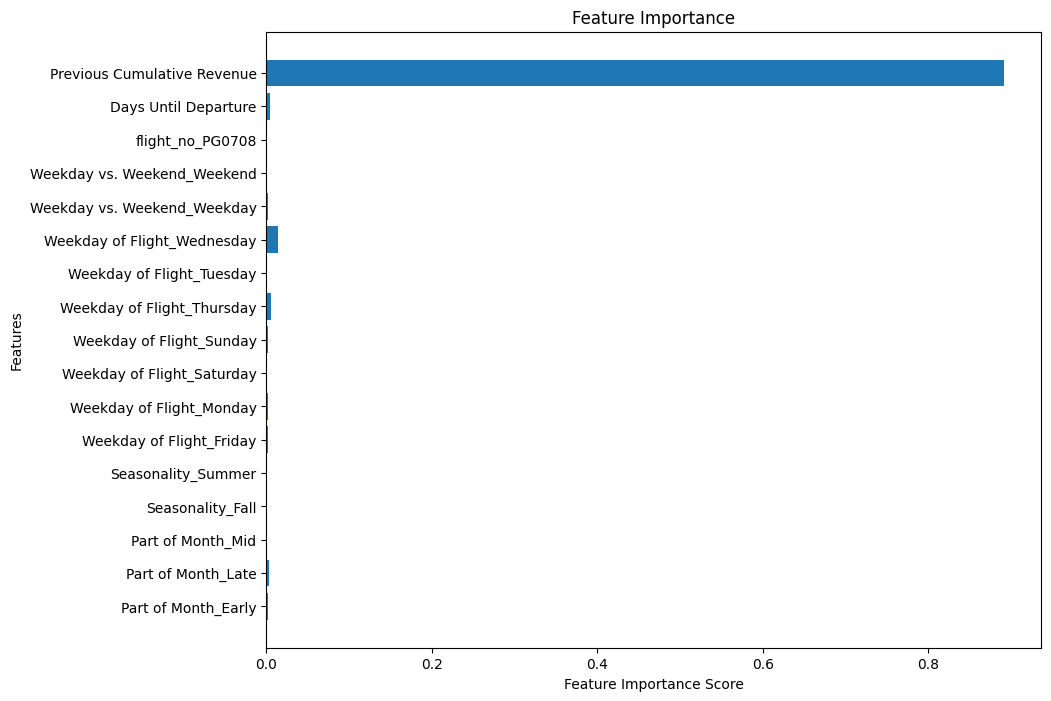

In [92]:
feature_importance = xgb_model_optimized.feature_importances_

filtered_feature_names = [name for name in feature_names if 'flight_id' not in name]
filtered_feature_importances = [feature_importance[i] for i, name in enumerate(feature_names) if 'flight_id' not in name]

# Assuming your feature names are stored in a list called 'feature_names'
feature_names = flight_to_test_X.columns
# Create a bar chart for feature importances
plt.figure(figsize=(10, 8))
plt.barh(filtered_feature_names, filtered_feature_importances)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

In the provided analysis, both predicted and actual revenues are displayed for the optimized model, revealing that while the model captures the overall trend of revenue, it tends to overestimate as the day of departure approaches. This overestimation suggests the model may be influenced by patterns observed in other flights, where revenues increase closer to the departure date. Initially, the model's predictions align closely with actual revenues up to 15 days before departure, indicating its effectiveness during this period. However, the need for model refinement and additional data becomes evident, particularly as the dataset used was limited due to time constraints.

For future research, expanding the dataset to include a broader range of flights, especially those similar in distance and pricing, would not only enhance the model's accuracy but also its comprehension of revenue trends. By integrating more diverse data and exploring different modeling techniques and data setups, a more generalized model can be achieved. This comprehensive approach would allow for a nuanced understanding of the factors influencing revenue trends and facilitate the development of a predictive model with improved accuracy and applicability across various flight scenarios. Achieving a generalized model in this manner would significantly benefit forecasting efforts, providing a robust tool for anticipating revenue fluctuations with greater precision.

<Figure size 1000x600 with 0 Axes>

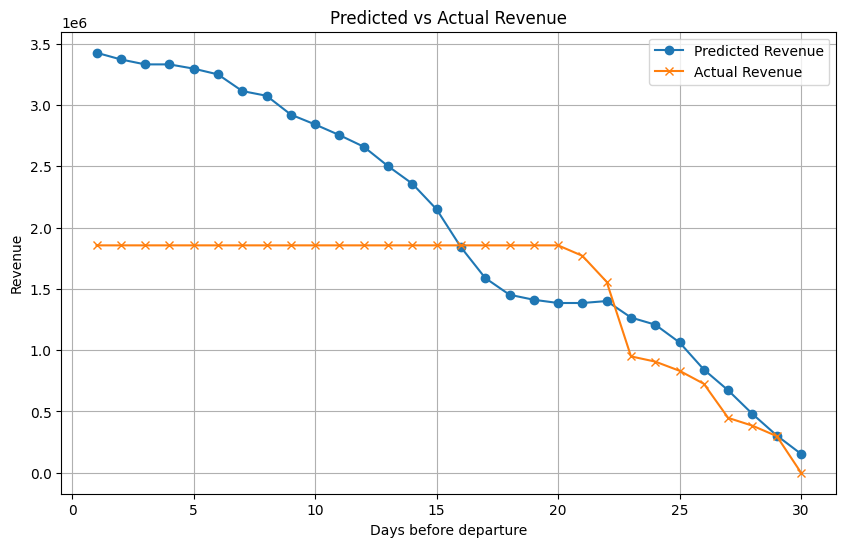

In [95]:
plt.figure(figsize=(10, 6))
# Create an array for x-axis from 1 to 30
x_axis = np.arange(1, 31)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(x_axis, test_predictions_reversed, label='Predicted Revenue', marker='o')
plt.plot(x_axis, flight_to_test_Y, label='Actual Revenue', marker='x')
plt.xlabel('Days before departure')
plt.ylabel('Revenue')
plt.title('Predicted vs Actual Revenue')
plt.legend()
plt.grid(True)
plt.show()